In [1]:
import csv
import math
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import geopandas as gpd
import random

os.environ['SSL_CERT_FILE'] = 'cacert.cer'

In [2]:
threshold = 0

In [3]:
if os.path.isfile('gb.shp'):
    uk = gpd.read_file('gb.shp')
    # Read the CRS of the shapefile
    crs = uk.crs
else:
    print('shapefile not found')

**Create graph from CSV:**

In [4]:
def create_graph_from_csv(csv_file):
    # Read the CSV file
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = [row for row in reader][1:] # Skip the first row
        
    # Create the networkx graph
    G = nx.DiGraph() # Use DiGraph instead of Graph to create a directed graph
    
    # Add nodes with their city labels
    for i in range(len(data)):
        G.add_node(i, city=data[i][0])
        
    for i in range(len(data)):
        for j in range(len(data[i])):
            if j > 0 and int(data[i][j]) > threshold:
                G.add_edge(i, j-1, weight=float(data[i][j]))
    
    # Check if pos.csv exists and read it if it does
    if os.path.isfile('pos.csv'):
        print("pos.csv found")
        with open('pos.csv', newline='') as f:
            reader = csv.reader(f)
            pos = {int(row[0]): (float(row[1]), float(row[2])) for row in reader}
    
    else:
        quit

    # Remove self-loops from adjacency matrix
    for i in range(len(G)):
        G[i][i]['weight'] = 0
    
    nx.set_node_attributes(G, pos, 'pos')

    print('Graph Created...')
    
    return G

**Plot Seperate Communities:**

In [5]:
def plot_seperate_communities(comm):
    # Plot the shapefile
    fig, ax = plt.subplots(figsize=(5, 9))
    uk.plot(ax=ax, color='white', edgecolor='black')

    # Get subgraph for community
    subgraph = G.subgraph(comm)

    # Compute edge colours based on node weights
    node_weights = {}
    for node in subgraph.nodes:
        node_weights[node] = sum([subgraph.edges[(node, neighbor)]['weight'] for neighbor in subgraph.neighbors(node)])
    edge_colours = {}
    for u, v, data in subgraph.edges(data=True):
        opacity = math.sqrt(data['weight'] / node_weights[u])
        edge_colours[(u, v)] = (0, 0, 0, opacity)

    # Draw the subgraph
    nx.draw_networkx_nodes(subgraph, pos, node_color='blue', node_size=10)
    nx.draw_networkx_edges(subgraph, pos, edge_color=list(edge_colours.values()), arrows=True)
    nx.draw_networkx_labels(subgraph, pos, labels=nx.get_node_attributes(subgraph, 'city'), font_size=8)
    ax.set_position([0.1, 0.1, 0.8, 0.8])

    plt.show()

In [6]:
if os.path.isfile('A.csv'):
    G = create_graph_from_csv('A.csv')
else:
    print("Commute data not found.")

pos = nx.get_node_attributes(G, 'pos')

pos.csv found
Graph Created...


**Community Detection:**

In [7]:
# run the Louvain Community Detection Algorithm
communities = list(nx.community.louvain_communities(G, weight='weight', resolution = 0.6))

In [8]:
# Define color map for the communities
num_communities = len(communities)
cm = plt.get_cmap('gist_rainbow')
c_colors = [colors.rgb2hex(cm(1. * i / num_communities)) for i in range(num_communities)]
random.shuffle(c_colors)

Community 1 : Barking and Dagenham, Barnet, Bexley, Sevenoaks, Bromley, Camden, Croydon, Brent, Enfield, Greenwich, Hackney, London, Hammersmith and Fulham, Haringey, London, Harrow, Elmbridge, Surrey, Gravesham, Epsom and Ewell, Islington, Kensington and Chelsea, Reigate and Banstead, Lambeth, Lewisham, Tandridge, Mole Valley, Newham, Richmond upon Thames, Southwark, Sutton, Tower Hamlets, London, Waltham Forest, Wandsworth, Westminster City of London, Redbridge, Woking, Ealing, Havering, London, Hillingdon, Hounslow, Guildford, Kingston upon Thames, Runnymede, Spelthorne, Merton, Waverley, Surrey, Southend-on-Sea, Thurrock, Basildon, Braintree, Brentwood, Castle Point, Chelmsford, Colchester, Epping Forest, Harlow, Maldon, Rochford, Tendring, Uttlesford, Broxbourne, Dacorum, East Hertfordshire, Hertsmere, St Albans, Three Rivers, Watford, Welwyn Hatfield, Dartford
Size =  67
Community 2 : Hartlepool, Middlesbrough, Redcar and Cleveland, Stockton-on-Tees
Size =  4
Community 3 : Darlin

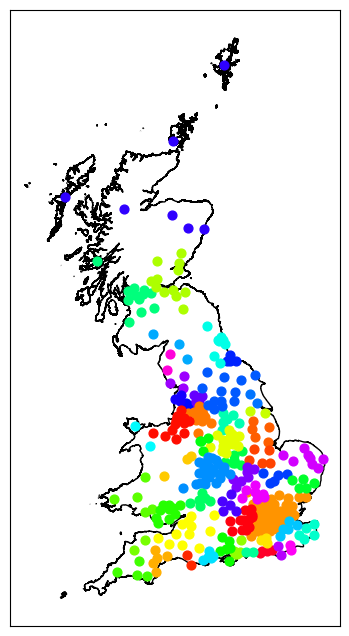

In [9]:
# Plot the shapefile
fig, ax = plt.subplots(figsize=(5, 8))
uk.plot(ax=ax, color='white', edgecolor='black')

# Plot each subgraph with community color
for i, comm in enumerate(communities):
    cities = [G.nodes[node]['city'] for node in comm]
    print(f'Community {i+1} : {", ".join(cities)}')
    print('Size = ' , len(cities))

    # Get subgraph for community
    subgraph = G.subgraph(comm)

    # Compute edge colours based on node weights
    node_weights = {}
    for node in subgraph.nodes:
        node_weights[node] = sum([subgraph.edges[(node, neighbor)]['weight'] for neighbor in subgraph.neighbors(node)])

    # Draw the subgraph with community color
    nx.draw_networkx_nodes(subgraph, pos, node_color=c_colors[i], node_size=40)

plt.show()

**Community Detection Analysis:**

In [10]:
import pandas as pd

attractiveness_df = pd.read_csv('sorted_data.csv')

In [11]:
def get_attractiveness(location):
    result_df = attractiveness_df.loc[attractiveness_df["Local Authority"] == location, "Attractiveness"]
    if not result_df.empty:
        return result_df.values[0]
    else:
        return 0.0

In [12]:
max_scores = []
other_sums = []
for i, comm in enumerate(communities):
    cities = [G.nodes[node]['city'] for node in comm]
    attractiveness_scores = []
    for location in cities:
        attractiveness_scores.append(get_attractiveness(location))

    print(f'Community {i+1} : {attractiveness_scores}')
    max_score = max(attractiveness_scores)
    other_scores = sum(attractiveness_scores) - max_score
    max_scores.append(max_score)
    other_sums.append(other_scores)
    print(f"Max value: {max_score}, Combination of other values: {other_scores}\n")

Community 1 : [0.4810053085600531, 0.4077322986795896, 0.3196856354083177, 0.4846002545412473, 0.3363948067325006, 2.643498279229839, 0.2838315516959339, 0.4790901322338804, 0.3749739557383434, 0.4185147228179907, 0.643532385868757, 1.114477241583645, 0.3909270051570165, 0.31864301414267, 0.5459132189707366, 0.2625093642633876, 0.5000984833563128, 1.5035836177474402, 1.406230791627576, 0.5727897146882706, 0.6398563918827641, 0.2975816170274458, 0.4423369703121035, 0.7482005343391482, 0.4821781790407551, 0.4974379441755072, 1.0962707205193172, 0.3776864208462462, 1.8308698095904865, 0.324856492319533, 0.4319781659978652, 9.47405691305678, 0.3216699761317367, 0.491132134820586, 0.4897535607919386, 0.345987610638738, 0.9062973139684852, 0.7216624317298986, 0.6960525363629785, 0.5436985721200387, 0.9413696779936764, 0.5114803332687463, 0.4557233883503209, 0.4757235165635238, 0.3101399702956929, 0.3378355353851396, 0.5282441630681403, 0.2594021544292128, 0.6145270738124914, 0.22490891023517

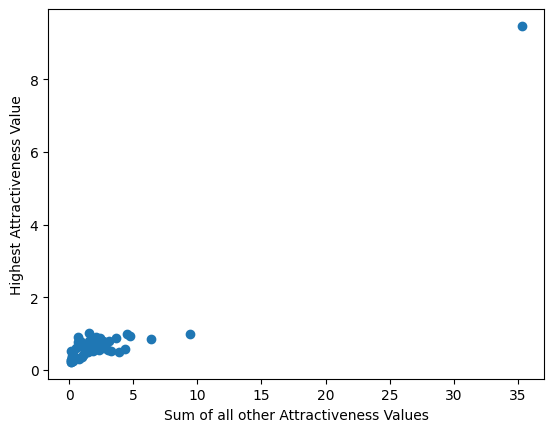

In [55]:
plt.scatter(other_sums, max_scores)
plt.ylabel('Highest Attractiveness Value')
plt.xlabel('Sum of all other Attractiveness Values')
plt.show()